In [1]:
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.vision.augment import *

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator
import nvidia.dali.plugin.pytorch as dalitorch

### I'm using the training set of the cats and dogs dataset to test the pipelines, it has 23K of jpg files of different sizes

In [3]:
source = untar_data(URLs.DOGS)
image_dir=source/'train'
items = get_image_files(image_dir)
len(items)

23000

In [4]:
means, stds=[102.,  100.,  90.],[72., 79., 80.]

## FASTAI v2

In [5]:
# converting stats to the format the  Normalize transform expects
tmeans,tstds = Tuple(broadcast_vec(1, 4, means, stds))/255

In [6]:
tfms = [[PILImage.create], [parent_label, Categorize()]]
dsrc = DataSource(items, tfms)
tdl = TfmdDL(dsrc, bs=10, shuffle=True,
             after_item=[ Resize(224, method = ResizeMethod.Crop), ToTensor],
             after_batch=[Cuda, ByteToFloatTensor, Normalize(tmeans,tstds)],
             num_workers=8)

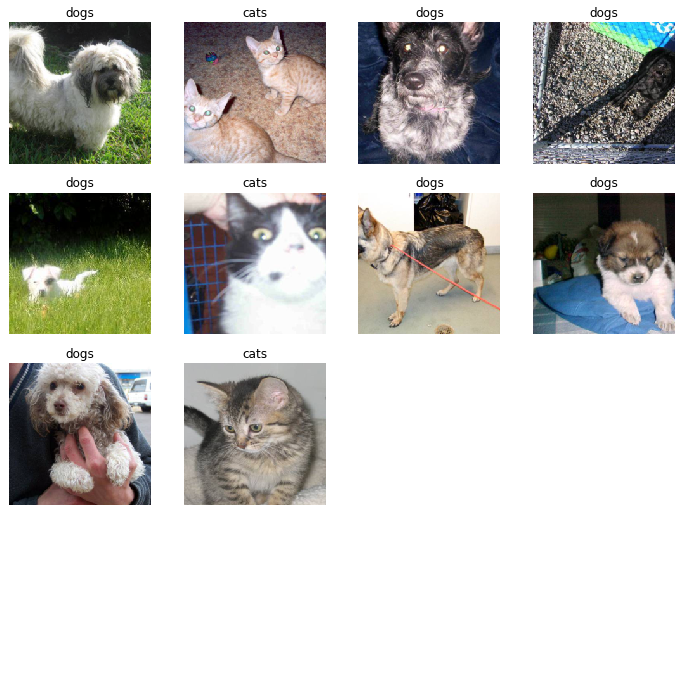

In [7]:
tdl.show_batch()

### Run the whole set throgh the pipeline, and collect stats to sanity check across pipelines

In [8]:
def test_pipeline(it):
    dogs,cats=0,0
    samples=0;iters=0
    mn =0; std=0
    for (x,y) in it:
        dogs += torch.sum(y==1)
        cats += torch.sum(y==0)
        samples += x.shape[0]
        mn += x.mean()
        std +=x.std()
        iters += 1
    print(dogs,cats, samples)
    print(mn / iters, std / iters)    

In [9]:
%%timeit
test_pipeline(tdl)

tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2417, device='cuda:0') tensor(0.8427, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2423, device='cuda:0') tensor(0.8428, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2427, device='cuda:0') tensor(0.8426, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2428, device='cuda:0') tensor(0.8429, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2416, device='cuda:0') tensor(0.8425, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2427, device='cuda:0') tensor(0.8424, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0.2421, device='cuda:0') tensor(0.8424, device='cuda:0')
tensor(11500, device='cuda:0') tensor(11500, device='cuda:0') 23000
tensor(0

## DALI pipeline

In [10]:
class DALIPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(DALIPipeline, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.FileReader(file_root = image_dir,random_shuffle=True)        
        self.tfms = compose(
            ops.ImageDecoder(device = "mixed"),
            ops.Resize(device = "gpu", resize_shorter = 224),
            ops.CropMirrorNormalize(device = "gpu", crop = (224, 224), mean = means, std = stds)
        )
    def define_graph(self):
        images, labels = self.input(name="Reader")
        return self.tfms(images), labels

### Test it and display a batch. I'm using the `TmfdDL` to decode to see that the data is encoded in the same way

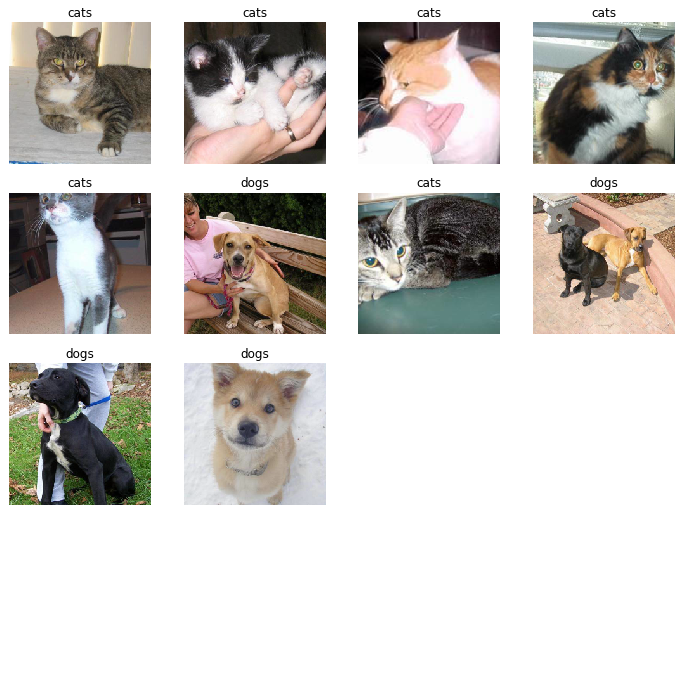

In [11]:
pipe = DALIPipeline(batch_size=10, num_threads=8, device_id = 0)
pipe.build()
dali_iter = DALIGenericIterator(pipe, ['data', 'label'], pipe.epoch_size("Reader"),fill_last_batch=False)
batch = next(iter(dali_iter))[0]
dali_x = batch['data']
dali_y = batch['label'].squeeze()

tdl.show_batch((dali_x,dali_y))

### Again running the whole set and collecting the same stats

In [12]:
def unpack(it):
    for batch in it: yield (batch[0]['data'], batch[0]['label'])

In [13]:
%%timeit
pipe = DALIPipeline(batch_size=10, num_threads=8, device_id = 0)
pipe.build()
dali_iter = DALIGenericIterator(pipe, ['data', 'label'], pipe.epoch_size("Reader"),fill_last_batch=False)
test_pipeline(unpack(dali_iter))

tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8460, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8463, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8459, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8457, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8460, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8458, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8462, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8455, device='cuda:0')
3.77 s ± 7.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Mixed approach of DALI Pipeline on top of fastai transforms

In [14]:
#Dali pipelines operates on numpy arrays with numbers
def encode_str(path):
    return np.frombuffer(bytes(str(path), 'UTF16'), dtype=np.uint8)

def decode_str(buf):
    return bytes(buf).decode('UTF16')

In [15]:
def read_file(path):
    path = decode_str(path)
    f = open(path, 'rb')
    return np.frombuffer(f.read(), dtype = np.uint8)

In [16]:
def extract_label(x):
    pa = decode_str(x)
    lbl = parent_label(pa)
    return encode_str(lbl)

In [17]:
def categorize(x):
    y = tfms[1][1](decode_str(x))
    return np.array([y], dtype = np.uint8)

In [18]:
np_items = [encode_str(f) for f in items]

In [19]:
class MixedPipeline(Pipeline):
    def __init__(self, np_items, batch_size, num_threads, device_id):
        super(MixedPipeline, self).__init__(batch_size, num_threads, device_id, exec_async=False, exec_pipelined=False)
        self.input_iter = iter(DataLoader(np_items, bs=batch_size, create_batch=noop, shuffle=True, num_workers = num_threads))
        self.path_input = ops.ExternalSource()
        self.y_tfms = compose(
            ops.PythonFunction(extract_label), 
            ops.PythonFunction(categorize)
        )
        self.x_tfms = compose(
            ops.PythonFunction(read_file),
            ops.ImageDecoder(device = "mixed", output_type = types.RGB),
            ops.Resize(device = "gpu", resize_shorter = 224),
            ops.CropMirrorNormalize(device = "gpu", crop = (224, 224), mean = means, std = stds)
        )
    def define_graph(self):
        self.paths = self.path_input()
        return (self.x_tfms(self.paths), self.y_tfms(self.paths))

    def iter_setup(self):
        self.feed_input(self.paths, next(self.input_iter))

In [20]:
pipe = MixedPipeline(np_items, batch_size=10, num_threads=8, device_id = 0)
pipe.build()

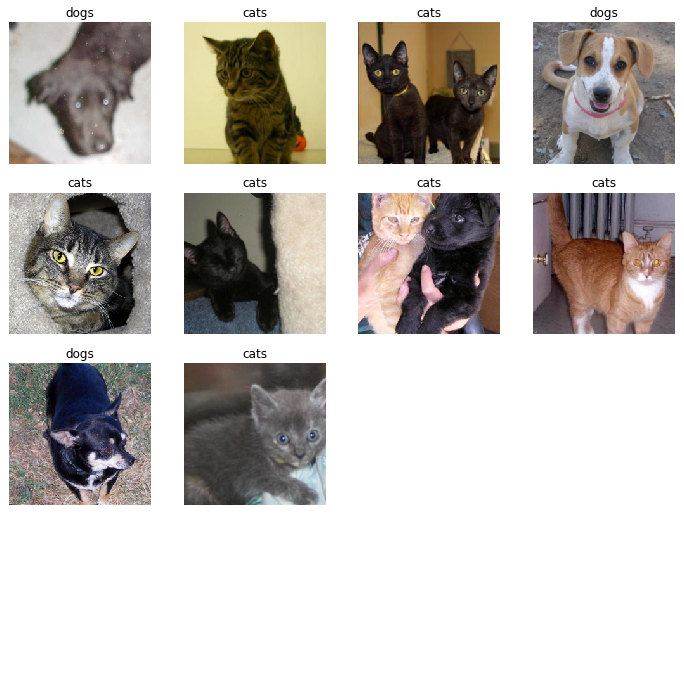

In [21]:
dali_iter = DALIGenericIterator(pipe, ['data','label'],size = len(items),fill_last_batch=False)
batch = next(iter(dali_iter))[0]
dali_x = batch['data']
dali_y = batch['label']

tdl.show_batch((dali_x,dali_y.squeeze()))

In [23]:
%%timeit
pipe = MixedPipeline(np_items, batch_size=10, num_threads=8, device_id = 0)
pipe.build()
dali_iter = DALIGenericIterator(pipe, ['data', 'label'],size = len(items), fill_last_batch=False)
test_pipeline(unpack(dali_iter))

tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8457, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8458, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8456, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8462, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8460, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8459, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8459, device='cuda:0')
tensor(11500) tensor(11500) 23000
tensor(0.2359, device='cuda:0') tensor(0.8459, device='cuda:0')
11 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
